In [1]:
import pandas as pd
df = pd.read_csv(r"C:\\Users\\JellevanAs\\Documents\\Studie\\Thesis\\df-BERT_cat.csv")


In [3]:

df = df.drop(df.columns[0], axis=1)

In [4]:
import pandas as pd
import numpy as np
from ast import literal_eval


df["embeddings"] = df["embeddings"].apply(literal_eval).apply(np.array)

# Separating the target variable and embeddings
x = df["embeddings"]
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' column from df
z = df.drop(["embeddings", "numerical_price"], axis=1)


# Deleting original dataframe for memory purpose
del df

# Explode the embedding arrays into separate columns
x = x.apply(pd.Series)

# Concatenating the exploded embeddings with the rest of the data
concatenated_df = pd.concat([x, z], axis=1).reset_index(drop=True)

In [5]:
concatenated_df.columns.tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [6]:
concatenated_df.columns = concatenated_df.columns.astype(str)

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(concatenated_df, y, test_size=0.2, random_state=42)
# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]



In [8]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_linear_svr(trial):
    # Parameters for LinearSVR
    C = trial.suggest_loguniform("C", 1e-3, 1e3)
    epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
    tol = trial.suggest_loguniform("tol", 1e-5, 1e-1)
    loss = trial.suggest_categorical("loss", ['epsilon_insensitive', 'squared_epsilon_insensitive'])

    # Ensure compatible settings for dual and loss
    if loss == 'epsilon_insensitive':
        dual = True  # dual must be True for 'epsilon_insensitive'
    else:
        dual = trial.suggest_categorical("dual", [True, False])

    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    intercept_scaling = trial.suggest_uniform("intercept_scaling", 0.1, 10)
    max_iter = trial.suggest_int("max_iter", 1000, 10000)

    linear_svr_params = dict(C=C, epsilon=epsilon, tol=tol, loss=loss, 
                             fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, 
                             dual=dual, max_iter=max_iter)

    clf_linear_svr = LinearSVR(**linear_svr_params, random_state=0)

    # StandardScaler for y
    scaler = StandardScaler()

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Scaling y_train
        y_train_scaled = scaler.fit_transform(y_train_fold.values.reshape(-1, 1))
        y_train_scaled = y_train_scaled.ravel()

        # Fitting the model
        clf_linear_svr.fit(X_train_fold, y_train_scaled)

        # Predicting and inverse transformation
        y_pred_scaled = clf_linear_svr.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        # R2 Score
        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)


    return float(np.mean(r2_scores))


C:\Users\JellevanAs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
study_svr = optuna.create_study(directions=['maximize'])
study_svr.optimize(Objective_linear_svr, n_trials=50)

[I 2024-01-07 12:36:44,745] A new study created in memory with name: no-name-f98c1e02-ea1e-46f4-b668-aa117a99e3d2
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_26792\3605284942.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_26792\3605284942.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform("epsilon", 1e-3, 1e1)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_26792\3605284942.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_26792\1847014462.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

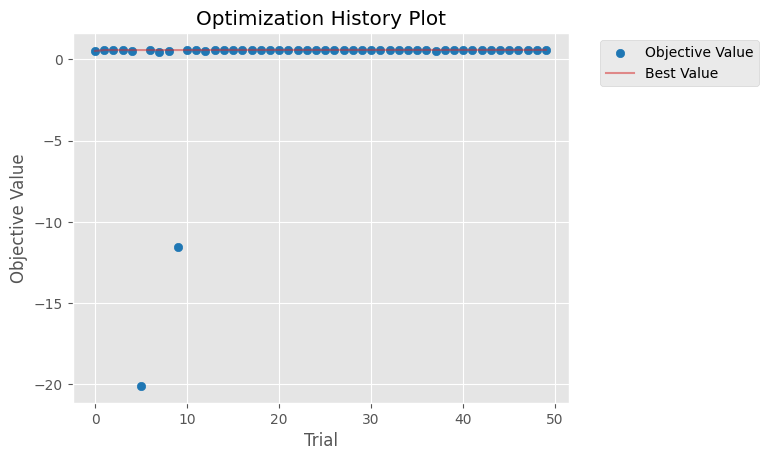

In [10]:
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_26792\3176666437.py:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_svr)
C:\Users\JellevanAs\AppData\Local\Temp\ipykernel_26792\3176666437.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_svr)


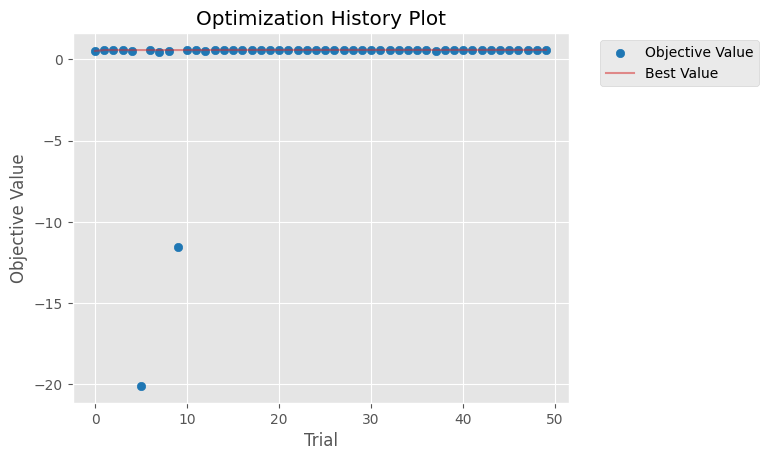

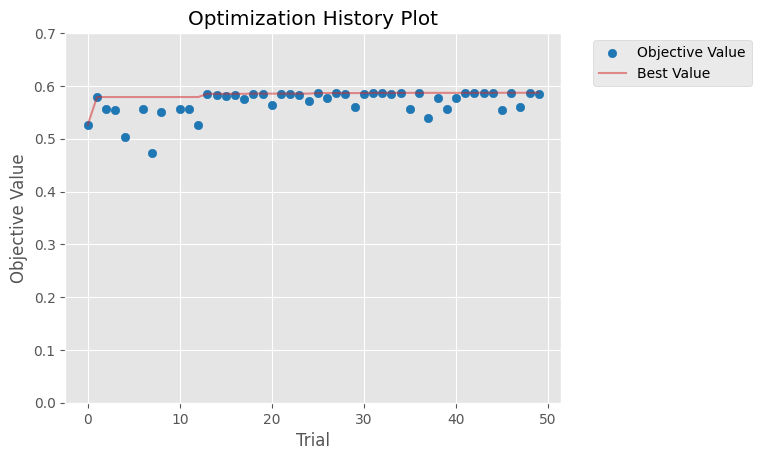

In [11]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in different format
optuna.visualization.matplotlib.plot_optimization_history(study_svr)

optuna_matplotlib.plot_optimization_history(study_svr)

plt.ylim(0, 0.7)

plt.show()